In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True

# pyEPR Startup Example
##### Single transmon qubit mode analysis  
Author: Zlatko Minev

## <div style="background:#BBFABB;line-height:2em;">Load pyEPR<div>

In [3]:
import pyEPR as epr
import matplotlib.pylab as plt
import numpy as np
import pyEPR.calcs
from pyEPR.calcs import Convert
import pandas as pd

This loads the `pyEPR` package under the shorthand name `epr`.

We can access the main different submodules, like this:
  * `epr.calcs`  : calculations tools 
  * `epr.ansys`  : tools for controlling ansys hfss, q3d, etc.
  * `epr.toolbox`: useful and handly toolbox for plotting, pythonic manipulations, etc. 
  * `epr.core`  : The core module of analysis functions. This does not need ot be accessed by the user typically. It essentually provides the main two classes: ProjectInfo, DistributedAnalysis, and QuantumAnalysis -- which represent the different stages of the simulation. Let us examine these next. 
  
EPR also has some handy functions, which we will explore:

In [49]:
print('Parsing unis:  1um =', 
      epr.parse_entry('1um', 'meters'), 'meters')

print(f"""For   L_J = 11 nH, the Josephson junction energy is
      E_J = {epr.calcs.Convert.Ej_from_Lj(11, 'nH', 'GHz'):.1f} GHz""")

Parsing unis:  1um = 1e-06 meters
For   L_J = 11 nH, the Josephson junction energy is
      E_J = 14.9 GHz


#### Load Ansys HFSS tutorial file  

Let us first determine where the example file is stored.
For tutorial, let us get the path to the tutorial folder.

In [4]:
# Load Path temporarily just to find where the tutorial folder is
# return path_to_project
from pathlib import Path
path_to_project = Path(epr.__file__).parent.parent / '_example_files'
print(f'We will the example project located in\n {path_to_project}')

We will the example project located in
 C:\Miniconda\envs\virenv\lib\site-packages\_example_files


## <div style="background:#BBFABB;line-height:2em;">Connect to Ansys HFSS<div>

Now, we will open Ansys Desktop and connect to a specific project.

You can use the following creation keyword arguments to specify which design to look at 

 * `project_path`: 
    Directory path to the hfss project file. Should be the directory, not the file.
    default = None: Assumes the project is open, and thus gets the project based on `project_name`
 * `project_name`:
    Name of the project within the project_path. "None" will get the current active one.
 * `design_name` :
    Name of the design within the project. "None" will get the current active one.
 * `setup_name`  :
    Name of the setup within the design. "None" will get the current active one.

Use `?epr.ProjectInfo` to see all the arguments

In [4]:
path_to_project = r'C:\Users\Lehnert Lab\Documents\Sheng-Xiang\Cavity_design'
pinfo = epr.ProjectInfo(project_path = path_to_project, 
                         project_name = 'DualCavity',
                         design_name  = 'Storage_cavity_external_decay_rate')

INFO 03:43PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:43PM [load_ansys_project]: 	File path to HFSS project found.
INFO 03:43PM [load_ansys_project]: 	Opened Ansys App
INFO 03:43PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 03:43PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Lehnert Lab/Documents/Sheng-Xiang/Cavity_design/
	Project:   DualCavity
INFO 03:43PM [connect_design]: 	Opened active design
	Design:    Storage_cavity_external_decay_rate [Solution type: Eigenmode]
INFO 03:43PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:43PM [connect]: 	Connected to project "DualCavity" and design "Storage_cavity_external_decay_rate" 😀 



In [146]:
fontsize= 18

Let's see what the design type was using the `design` object

In [6]:
pinfo.design.solution_type

'Eigenmode'

Let us see what all the object in the design are. `pinfo` contains a function to retrieve these for convenience.

In [7]:
pinfo.get_all_object_names()

['Cavity1',
 'SapphireRod',
 'SMA_RO_pin1',
 'SMA_RO_pin2',
 'SMA_Storage_pin',
 'QubitSapphire',
 'rect_jj1',
 'RO_pin2_1',
 'RO_pin1_1',
 'Storage_pin_1',
 'Rectangle7',
 'TransmonPad1_finger',
 'TransmonPad2',
 'TranmonPad2_finger',
 'TransmonPad1',
 'line_jj1']

Let's see what variables there are in the design. 

In [8]:
pinfo.get_all_variables_names()

['$sappTand',
 '$boxZ',
 '$cavityHeight',
 '$boxY',
 '$boxX',
 '$boxHeight',
 '$coaxRad',
 '$coaxHeight',
 '$port2Len',
 '$portLen',
 '$coaxOffset',
 '$port2offset',
 '$port1Offset',
 '$pin2len',
 '$pin1len',
 '$cavityRadius',
 '$rodOffset',
 '$rodRad',
 '$qubitHole',
 '$qubSapZ',
 '$qubSapThick',
 '$qubitCentDist',
 '$padHeight',
 '$padLen',
 '$fingerHeight',
 '$fingerLen',
 '$junctionLen',
 '$LJ',
 '$qubHoleOffset',
 '$portRadius',
 'cavityRadius',
 'cavityHeight',
 'coaxRad',
 'coaxHeight',
 'qubSapThick',
 'qubSapZ',
 'qubHoleOffset',
 'qubitHole',
 'qubitCentDist',
 'fingerLen',
 'junctionLen',
 'fingerHeight',
 'padHeight',
 'padLen',
 'LJ',
 'smallfingerlen',
 'smallfingerheight',
 'actualJunctionLen',
 'actualJunctionHeight',
 'rodOffset',
 'rodRad',
 'padHeight2',
 'pin2Len',
 'pin1Len',
 'cavitySep',
 'CenterOffset',
 'coaxHeightStorage',
 'PinHoleRadius',
 'PinPos',
 'pinStorageLen',
 'SMAPinRadius',
 'RO_elevated',
 'HoleDepth',
 'PadOffset',
 'ROpin2Len']

We can also get the names of the setups

In [9]:
pinfo.design.get_setup_names()

('Setup1',)

We can also get information such as mesh statistic and convergence (if you have already solved the model)

In [10]:
pinfo.setup.get_mesh_stats()

ERROR in MESH reading operation.
No columns to parse from file
ERROR!  Error in trying to read temporary MESH file C:\Users\LEHNER~2\AppData\Local\Temp\tmpeonx9mm0
. Check to see if there is a mesh available for this current variation.                   If the nominal design is not solved, it will not have a mesh.,                    but will show up as a variation.


We can also see how many modes we solved for

In [11]:
pinfo.setup.n_modes

'5'

##  <div style="background:#BBFABB;line-height:2em;"> Josephson tunnel junctions (non-linear elemetns) </div>

To analysze the quantum part of the model, let us specify the junctions in the model. 

The junciton is defined as described in the paper and on the landing page of pyEPR. There is a rectangle sheet inductance and a polyline that defines the current and voltage on the sheet.  

Let us call the single junction `j1`. A junction has the following properties:

  1. **Lj_variable** : Name of HFSS variable that specifies junction inductance Lj defined on the boundary condition in HFSS
  2. **rect**        : Name of HFSS rectangle on which lumped boundary condition is specified.
  3. **line**        : Name of HFSS polyline which spans the length of the recntalge. Used to define the voltage across the junction. 
  4. **Cj_variable** : (Optional) Name of HFSS variable that specifies junction lumped capacitance Cj defined on the boundary condition in HFSS. This is optional.

In [51]:
pinfo.junctions['j1'] = {'Lj_variable' : 'LJ', 
                         'rect'        : 'rect_jj1', 
                         'line'        : 'line_jj1', 
                         'length'      : epr.parse_units('10um')}


# Check that valid names of variables and objects have been supplied.
# An error is raised with a message if something is wrong.
pinfo.validate_junction_info()  

## <div style="background:#BBFABB;line-height:2em;">Micrwoave Analysis: <br>Run analysis on an eigenmode solution  <div>

Assumeing we have field solutions saved for the HFSS *eigenmode* design, we can now create the analysis object from the 
calss `DistributedAnalysis`.

**Run analysis:** (Tutorial action) Run the analysis in the design model. 
This can be done manually, or using pyEPR.

In [14]:
# Calling this function will run an analysis of the design in the background. 
# The console will wait for HFSS to complete.
pinfo.setup.analyze()

INFO 01:58AM [analyze]: Analyzing setup Setup1


**Run optimetrics**

The following will get the frequencies and Qs from HFSS. 

In [4]:
# Calling this function will run an analysis on all the optimetrics  the design in the background. 
# The console will wait for HFSS to complete.
# This requires optimetrics license by HFSS. 
pinfo.design.optimetrics.solve_setup(pinfo.design.optimetrics.get_setup_names()[0])

**EPR Analysis object**

Let us introduce the core analysis object of `pyEPR`, which will be a class instance of `epr.DistributedAnalysis`. This is how we will run most of our analysis.

Let us recover the eigenmode frequencies of the first variation we ran, which is indexed by '0'.

In [5]:
# This is the core object for interacting with HFSS
# and running analysis within HFSS.
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 

Design "Storage_cavity_external_decay_rate" info:
	# eigenmodes    5
	# variations    7


In [6]:
eprh.get_ansys_variables()

variation,0,1,2,3,4,5,6
$boxHeight,200mm,200mm,200mm,200mm,200mm,200mm,200mm
$boxX,30mm,30mm,30mm,30mm,30mm,30mm,30mm
$boxY,30mm,30mm,30mm,30mm,30mm,30mm,30mm
$boxZ,80mm,80mm,80mm,80mm,80mm,80mm,80mm
$cavityHeight,40mm,40mm,40mm,40mm,40mm,40mm,40mm
...,...,...,...,...,...,...,...
rodRad,2mm,2mm,2mm,2mm,2mm,2mm,2mm
ROpin2Len,9.2599999999999998mm,9.2599999999999998mm,9.2599999999999998mm,9.2599999999999998mm,9.2599999999999998mm,9.2599999999999998mm,9.2599999999999998mm
smallfingerheight,0.0001mm,0.0001mm,0.0001mm,0.0001mm,0.0001mm,0.0001mm,0.0001mm
smallfingerlen,0.0024499999999999999mm,0.0024499999999999999mm,0.0024499999999999999mm,0.0024499999999999999mm,0.0024499999999999999mm,0.0024499999999999999mm,0.0024499999999999999mm


In [75]:
eprh.get_variables('1')

OrderedDict([('_$boxHeight', '200mm'),
             ('_$boxX', '30mm'),
             ('_$boxY', '30mm'),
             ('_$boxZ', '80mm'),
             ('_$cavityHeight', '40mm'),
             ('_$cavityRadius', '9mm'),
             ('_$coaxHeight', '8.5mm'),
             ('_$coaxOffset', '2mm'),
             ('_$coaxRad', '2.5mm'),
             ('_$fingerHeight', '0.002mm'),
             ('_$fingerLen', '0.01mm'),
             ('_$junctionLen', '0.0050000000000000001mm'),
             ('_$LJ', '5nH'),
             ('_$padHeight', '0.20000000000000001mm'),
             ('_$padLen', '1.5mm'),
             ('_$pin1len', '5mm'),
             ('_$pin2len', '5mm'),
             ('_$port1Offset', '8mm'),
             ('_$port2Len', '14mm'),
             ('_$port2offset', '9mm'),
             ('_$portLen', '14mm'),
             ('_$portRadius', '1.25mm'),
             ('_$qubHoleOffset', '1mm'),
             ('_$qubitCentDist', '6mm'),
             ('_$qubitHole', '1mm'),
             ('_$qubS

In [7]:
ROpin1 = []
ROpin2 = []
LJ = []
for i in eprh.variations:
#     if int(float(eprh.get_variables(str(i))['_pin1Len'].split('m')[0]))==8:
        ROpin2_temp = float(eprh.get_variables(str(i))['_ROpin2Len'].split('m')[0])
        ROpin1.append(float(eprh.get_variables(str(i))['_pinStorageLen'].split('m')[0]))
        ROpin2.append(ROpin2_temp)
        LJ.append(float(eprh.get_variables(str(i))['_LJ'].split('n')[0]))

d = {'Storage':ROpin1,'RO2':ROpin2}
df = pd.DataFrame(data = d)
df

,Storage,RO2
0,7.0,9.26
1,6.0,9.26
2,6.5,9.26
3,7.5,9.26
4,8.0,9.26
5,8.5,9.26
6,9.0,9.26


INFO 03:22PM [hfss_report_full_convergence]: Creating report for variation 0
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:22PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


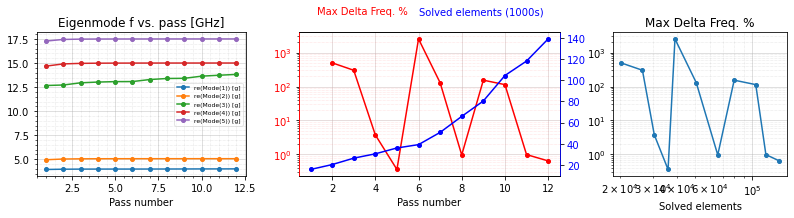

INFO 03:22PM [hfss_report_full_convergence]: Creating report for variation 1
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:22PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


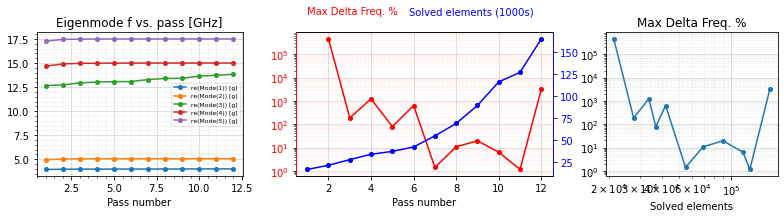

INFO 03:22PM [hfss_report_full_convergence]: Creating report for variation 2
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:22PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


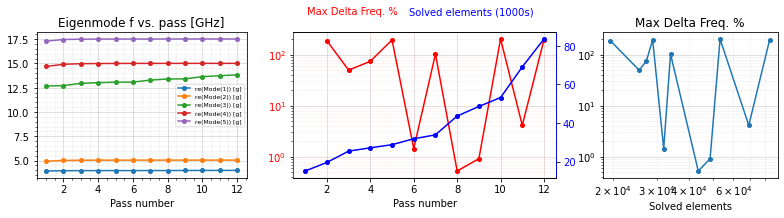

INFO 03:22PM [hfss_report_full_convergence]: Creating report for variation 3
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:22PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


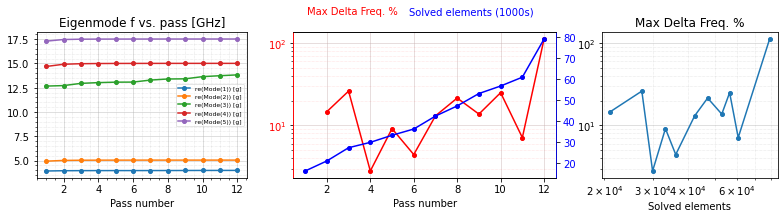

INFO 03:22PM [hfss_report_full_convergence]: Creating report for variation 4
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:22PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


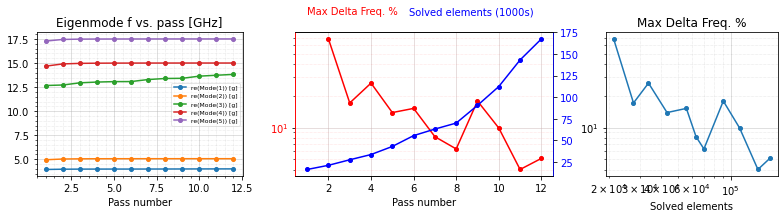

INFO 03:22PM [hfss_report_full_convergence]: Creating report for variation 5
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:23PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


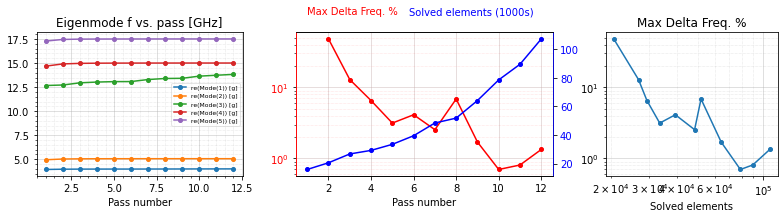

INFO 03:23PM [hfss_report_full_convergence]: Creating report for variation 6
C:\Miniconda\envs\virenv\lib\site-packages\pyEPR\ansys.py:1225: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  index_col=0).drop('Unnamed: 3', 1)
INFO 03:23PM [hfss_report_f_convergence]: Saved convergences to C:\data-pyEPR\DualCavity\Storage_cavity_external_decay_rate\hfss_eig_f_convergence.csv


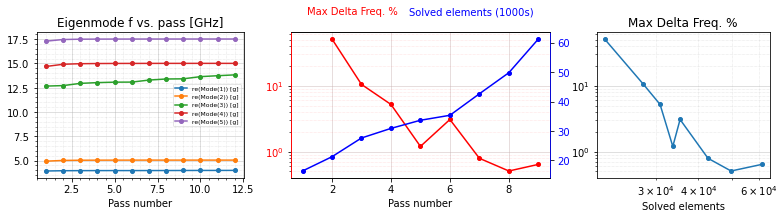

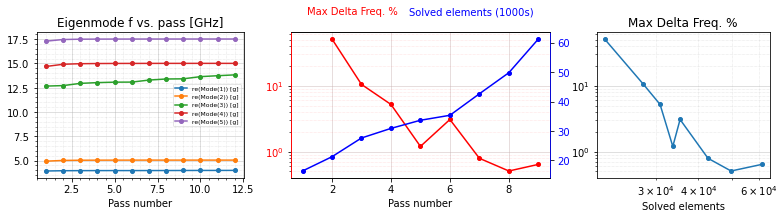

In [8]:
eprh.hfss_report_full_convergence();

We can see that the convergence wasn't actually terrific, though we only used 60,000 tets. However, there seems to be a divergence above 15 passes in this example. We will probably need to change our mesh operations to create a monotonic convergence.

However, for the purpose of the tutorial, let us press forward. 

You can use these autogenerated reports to keep track of your simulations.
This is still all at the clasical level. Take a look at the other methods, including
 * `hfss_report_full_convergence`
 * `hfss_report_f_convergence`
 * `get_convergence`
 * `get_mesh_statistics`
 * `get_freqs_bare_pd`
 * ...
 
For example, you can get tables of the freqs and Qs using 
```python
Fs, Qs = eprh.get_freqs_bare_pd(variation='0')
```

In [9]:
import pandas as pd
Fs, Qs = [],[]
for variation in eprh.variations: # just for the first 2
#     if int(float(eprh.get_variables(str(variation))['_pin1Len'].split('m')[0]))==8:
        Ft, Qt = eprh.get_freqs_bare_pd(variation=variation, frame=False)
        Fs.append(Ft)
        Qs.append(Qt)

In [28]:
Qs[1,2]

7880.284851438468

Text(0.5, 0, 'Pin_depth (mm)')

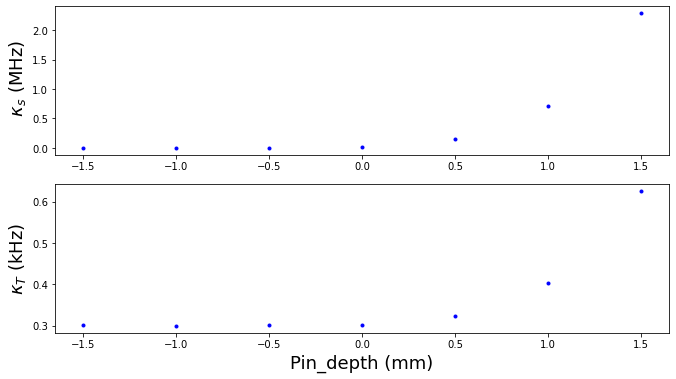

In [10]:
Fs = np.array(Fs)
Qs = np.array(Qs)

fontsize=18
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,6))
ax1.plot(np.array(ROpin1)-7.5,Fs[:,1]*1e3/Qs[:,1],'b.')
ax1.set_ylabel(r' $\kappa_{s}$ (MHz)',fontsize= fontsize)
ax2.plot(np.array(ROpin1)-7.5,Fs[:,0]*1e6/Qs[:,0],'b.')
ax2.set_ylabel(r'$\kappa_T$ (kHz)',fontsize= fontsize)
plt.xlabel('Pin_depth (mm)',fontsize= fontsize)

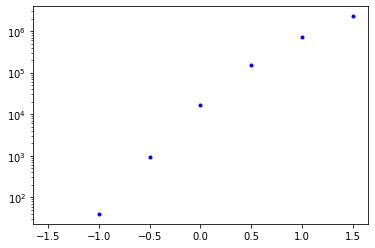

In [11]:
y = Fs[:,1]*1e9/Qs[:,1]
plt.semilogy(np.array(ROpin1)-7.5,y-min(y),'b.')

-0.9910887332103413


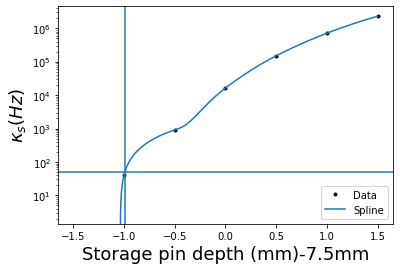

In [12]:
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline

x = np.array(ROpin1)-7.5
y = np.array(Fs[:,1]/Qs[:,1]*10**9) # kHz
y = y-min(y)

ind = np.lexsort((y,x))
x = x[ind]
y = y[ind]

spl = InterpolatedUnivariateSpline(x,y)
xs = np.linspace(min(x), max(x), 1000)
plt.semilogy(x,y,'k.', label = 'Data')
plt.semilogy(xs, spl(xs), label = 'Spline')
plt.legend()

ys = spl(xs)
ind = np.argmin((ys - 1.00)**2)
xbest = xs[ind]
# plt.axvline(xbest)
# plt.axhline(1)
# print(xbest)

spl2 = UnivariateSpline(x, y - 50, s=0)
xbest = spl2.roots()[0]
plt.axvline(xbest)
plt.axhline(spl(xbest))

plt.xlabel('Storage pin depth (mm)-7.5mm',fontsize = fontsize)
plt.ylabel(r'$\kappa_{s} (Hz)$',fontsize=fontsize)
print(xbest)

In [17]:
y

array([0.00000000e+00, 3.97991295e+01, 9.10961756e+02, 1.63525461e+04,
       1.50414020e+05, 7.13270769e+05, 2.29112611e+06])

In [18]:
temp = eprh.get_ansys_variables()
d = np.array([Qs[:,1],Fs[:,1]])
index = ['Storage_Q','F_RO (GHz)']
df = pd.DataFrame(data=d, columns = temp.columns, index= index)
result = temp.append(df)
result.to_csv('Gen4_storage_external_decay_rate_all_parameters.csv')

In [127]:
np.sort(Fs[:,2]*1e3/Qs[:,2])

array([0.00600367, 0.00602312, 0.00604816, 0.00610432, 0.00611833,
       0.00612345, 0.00613089, 0.00614678, 0.00617918, 0.00618845,
       0.00662549, 0.00755131, 0.01201453, 0.02959563, 0.08469234,
       0.21681204, 0.48088198, 0.98912024, 1.79490089])

Text(0.5, 0, 'Pin_depth (mm)')

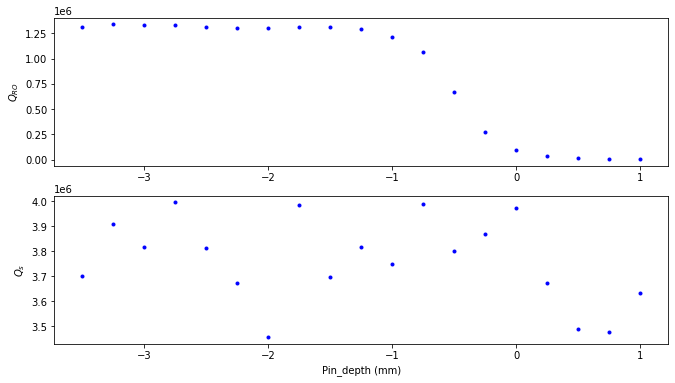

In [99]:
Fs = np.array(Fs)
Qs = np.array(Qs)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,6))
ax1.plot(np.array(ROpin2)-8.5,Qs[:,2],'b.')
ax1.set_ylabel(r'$Q_{RO}$')
ax2.plot(np.array(ROpin2)-8.5,Qs[:,1],'b.')
ax2.set_ylabel(r'$Q_s$')
plt.xlabel('Pin_depth (mm)')

The Q is infinite, since we have not included dissipation yet in this example. The row index is the mode number

####  Full analysis

Let's now jump ahead to the full analysis.

##### Getting more info

In general, to see more info when running commands , set the logger level

In [ ]:
import logging
epr.logger.setLevel(logging.DEBUG)

## <div style="background:#BBFABB;line-height:2em;"> Quantum Hamiltonian Analysis:<br> Load mw-analysis results and perform hamiltonian analysis on the solutions  <div>

We will now postprocess the mw analysis to obtain the quantum Hamiltonian. 

The code object of postprocessing is `epra`, an instance of `epr.QuantumAnalysis`.

In [ ]:
%matplotlib inline
# plot the figures in the notebook. 

# This is the core object for working with post processing data from HFSS
# This iwll load the saved solutions from above
# file = r'C:\data-pyEPR\DualCavity\L Two Post Memory with a sapphire rod_eigenmode_gen3\2022-01-18 11-26-20.npz'
epra = epr.QuantumAnalysis(eprh.data_filename)

# Analyze 
result = epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 4)

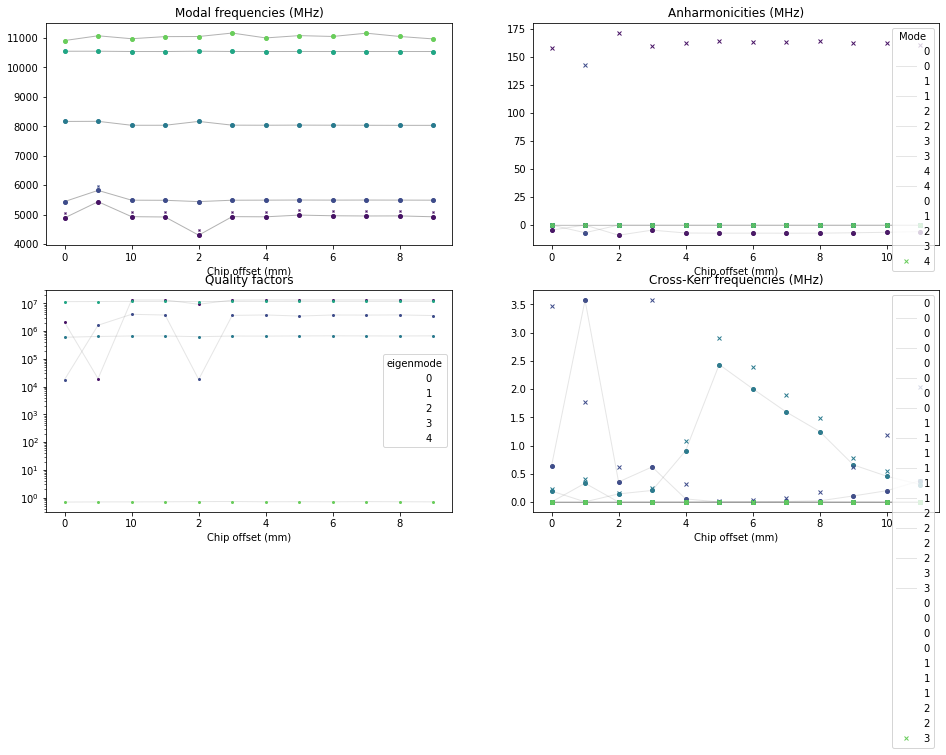

In [38]:
epra.plot_hamiltonian_results(x_label = 'Chip offset (mm)');

In [46]:
np.array(result['1']['chi_O1'])[1,1]

142.2902780398406

In [82]:
result['1'].keys()

odict_keys(['f_0', 'f_1', 'f_ND', 'chi_O1', 'chi_ND', 'ZPF', 'Pm_normed', 'Pm_raw', '_Pm_norm', '_Pm_cap_norm', 'hfss_variables', 'Ljs', 'Cjs', 'Q_coupling', 'Qs', 'fock_trunc', 'cos_trunc'])

In [84]:
result['1']['f_0'][0]

5439.2715886999995

In [94]:
RO_dis = []
St_dis = []
Anaha = []
C = []
for i in range(3,12):
    chi = np.array(result[str(i)]['chi_O1'])
    St_dis.append(chi[0,1])
    RO_dis.append(chi[0,2])
    Anaha.append(chi[0,0])
    C.append(10**6/(2*np.pi)**2/(np.array(result[str(i)]['f_0'])[0]/1000)**2/10)

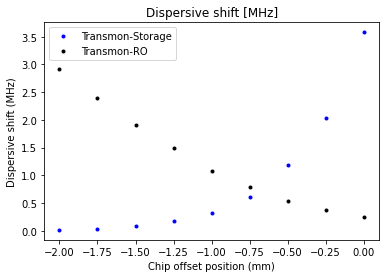

In [57]:
dist = np.array([0,-1,-2,-1.75,-1.5,-1.25,-0.75,-0.5,-0.25])
plt.title('Dispersive shift [MHz]')
plt.plot(dist, St_dis, 'b.',label = 'Transmon-Storage')
plt.plot(dist, RO_dis, 'k.', label = 'Transmon-RO')
plt.xlabel('Chip offset position (mm)')
plt.ylabel('Dispersive shift (MHz)')
plt.legend()

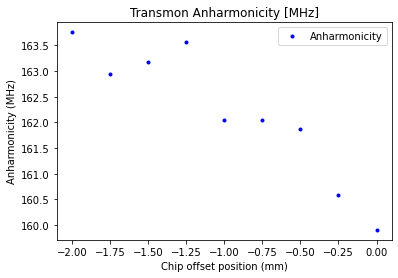

In [58]:
dist = np.array([0,-1,-2,-1.75,-1.5,-1.25,-0.75,-0.5,-0.25])
plt.title('Transmon Anharmonicity [MHz]')
plt.plot(dist, Anaha, 'b.',label = 'Anharmonicity')
plt.xlabel('Chip offset position (mm)')
plt.ylabel('Anharmonicity (MHz)')
plt.legend()

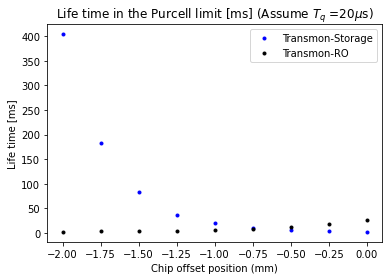

In [77]:
plt.title(r'Life time in the Purcell limit [ms] (Assume $T_q$ =20$\mu$s)')
plt.plot(dist, 2*np.array(Anaha)/np.array(St_dis)*20/1000, 'b.',label = 'Transmon-Storage')
plt.plot(dist, 2*np.array(Anaha)/np.array(RO_dis)*20/1000, 'k.', label = 'Transmon-RO')
plt.xlabel('Chip offset position (mm)')
plt.ylabel(r'Life time [ms]')
plt.legend()

In [69]:
T_pSt = 2*np.array(Anaha)/np.array(St_dis)*20/1000
T_pRO = 2*np.array(Anaha)/np.array(RO_dis)*20/1000

In [97]:
Lj = 10*np.ones(len(T_pSt))
C = np.array(C)
EJ = Convert.Ej_from_Lj(Lj, 'nH', "GHz")
EC = Convert.Ec_from_Cs(C, 'fF', "MHz")

In [104]:
d = {'dist': dist, 'LJ [nH]':10*np.ones(len(T_pSt)),'C [fF]':C, 'EJ [GHz]':EJ, 'EC [MHz]':EC, 'EJ/EC':EJ/EC*1000, 'Alpha [MHz]':Anaha, 'Chi_RO [MHz]':RO_dis, 'Chi_Storage [MHz]':St_dis,'Purcell_Storage [ms]': T_pSt, 'Purcell_RO [ms]': T_pRO}
pf = pd.DataFrame(data = d)

In [105]:
pf

,dist,LJ [nH],C [fF],EJ [GHz],EC [MHz],EJ/EC,Alpha [MHz],Chi_RO [MHz],Chi_Storage [MHz],Purcell_Storage [ms],Purcell_RO [ms]
0,0.00,10.0,97.715016,16.346151,198.231860,82.459758,159.903635,0.243418,3.581067,1.786100,26.276335
1,-1.00,10.0,97.939267,16.346151,197.777970,82.648999,162.039276,1.085056,0.312577,20.735941,5.973491
2,-2.00,10.0,95.631664,16.346151,202.550375,80.701659,163.758472,2.914580,0.016200,404.347701,2.247438
3,-1.75,10.0,96.518820,16.346151,200.688625,81.450313,162.945506,2.397080,0.035757,182.279359,2.719066
4,-1.50,10.0,96.807451,16.346151,200.090274,81.693882,163.170557,1.905263,0.077918,83.765339,3.425681
5,-1.25,10.0,96.695714,16.346151,200.321488,81.599590,163.565460,1.491759,0.175800,37.216161,4.385841
6,-0.75,10.0,97.888286,16.346151,197.880974,82.605977,162.045834,0.784716,0.615798,10.525903,8.260102
7,-0.50,10.0,97.736924,16.346151,198.187425,82.478247,161.879485,0.544133,1.179948,5.487682,11.900003
8,-0.25,10.0,98.196327,16.346151,197.260222,82.865928,160.575943,0.366715,2.033134,3.159180,17.515077


In [ ]:
temp = np.zeros([len(result.keys()),4])
for i in result.keys():
    result['1']

In [ ]:
temp = result['1']
np.array(temp['f_0'])

## <div style="background:#BBFABB;line-height:2em;"> Swept variable analysis driven thorugh pyEPR:<br> Sweep variable in hfss, analyze microwaves, then analyze quantum<div>

Let us now run a more complicated example, where we will sweep $L_j$. This demonstrates some of the `pyEPR` funcationality. 

**Classical microwave, distributed analysis**

Sweep variable in HFSS, run circuits

**EPR mw analysis**

Classical-to-quantum bridge. 

In [ ]:
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 
eprh.hfss_report_full_convergence()

In [ ]:
# Do EPR analysis for all modes and all variations 
eprh.do_EPR_analysis();

**Quantum analysis** 

Perform the analysis and plot the results.

In [ ]:
# This is the core object for working with post processing data from HFSS
# This will load the saved solutions from above
epra = epr.QuantumAnalysis(eprh.data_filename)

In [ ]:
# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15);

In [ ]:
#Custom sort of columns
def do_sort_index(df:pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        df.columns = df.columns.astype(float)
        return df.sort_index(axis=1)
    else:
        return df

epra.results.do_sort_index = do_sort_index
df = epra.results.get_frequencies_HFSS(vs='Lj_1')
df

In [ ]:
epra.results.sort_index = True
epra.plot_hamiltonian_results(swp_variable='Lj_1');

There is some jitter, since we have have run some of the runs to only a few passes here.

Please see Part II of the tutorial to continue. You will find it in the tutorial folder as a jupyter notebook. 

In [ ]:
epra.quick_plot_mode(0,0,1,numeric=True,swp_variable='Lj_1')

In [ ]:
swp_variable = 'Lj_1'
epra.report_results(swp_variable=swp_variable, numeric=True)